In [353]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

import warnings
warnings.filterwarnings('ignore')

In [354]:
# read the column description
dict_df = pd.read_csv("data-dictionary.csv", sep=",", header=0)
dict_df.head(10)

,Column Name,Description
0,country,Name of the country
1,child_mort,Death of children under 5 years of age per 100...
2,exports,Exports of goods and services per capita. Give...
3,health,Total health spending per capita. Given as %ag...
4,imports,Imports of goods and services per capita. Give...
5,Income,Net income per person
6,Inflation,The measurement of the annual growth rate of t...
7,life_expec,The average number of years a new born child w...
8,total_fer,The number of children that would be born to e...
9,gdpp,The GDP per capita. Calculated as the Total GD...


# 1. Read and visualise the data

In [355]:
# read the dataset
country_df = pd.read_csv("Country-data.csv", sep=",", header=0)
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


## Convert `export`, `Health`, `imports` columns from % to their actual values

In [356]:
varlist = ['exports', 'health', 'imports']

# Applying the function to the housing list
country_df['exports_actual'] = (country_df['gdpp']/100)*country_df['exports']
country_df['health_actual'] = (country_df['gdpp']/100)*country_df['health']
country_df['imports_actual'] = (country_df['gdpp']/100)*country_df['imports']

country_df.drop(varlist, axis=1, inplace=True)
country_df

,country,child_mort,income,inflation,life_expec,total_fer,gdpp,exports_actual,health_actual,imports_actual
0,Afghanistan,90.2,1610,9.44,56.2,5.82,553,55.30,41.9174,248.297
1,Albania,16.6,9930,4.49,76.3,1.65,4090,1145.20,267.8950,1987.740
2,Algeria,27.3,12900,16.10,76.5,2.89,4460,1712.64,185.9820,1400.440
3,Angola,119.0,5900,22.40,60.1,6.16,3530,2199.19,100.6050,1514.370
4,Antigua and Barbuda,10.3,19100,1.44,76.8,2.13,12200,5551.00,735.6600,7185.800
...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,2950,2.62,63.0,3.50,2970,1384.02,155.9250,1565.190
163,Venezuela,17.1,16500,45.90,75.4,2.47,13500,3847.50,662.8500,2376.000
164,Vietnam,23.3,4490,12.10,73.1,1.95,1310,943.20,89.6040,1050.620
165,Yemen,56.3,4480,23.60,67.5,4.67,1310,393.00,67.8580,450.640


In [357]:
# basics of the df
country_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country         167 non-null    object 
 1   child_mort      167 non-null    float64
 2   income          167 non-null    int64  
 3   inflation       167 non-null    float64
 4   life_expec      167 non-null    float64
 5   total_fer       167 non-null    float64
 6   gdpp            167 non-null    int64  
 7   exports_actual  167 non-null    float64
 8   health_actual   167 non-null    float64
 9   imports_actual  167 non-null    float64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


# 2. Clean the data

In [358]:
# missing values
round(100*(country_df.isnull().sum())/len(country_df), 2)

country           0.0
child_mort        0.0
income            0.0
inflation         0.0
life_expec        0.0
total_fer         0.0
gdpp              0.0
exports_actual    0.0
health_actual     0.0
imports_actual    0.0
dtype: float64

# 3. EDA

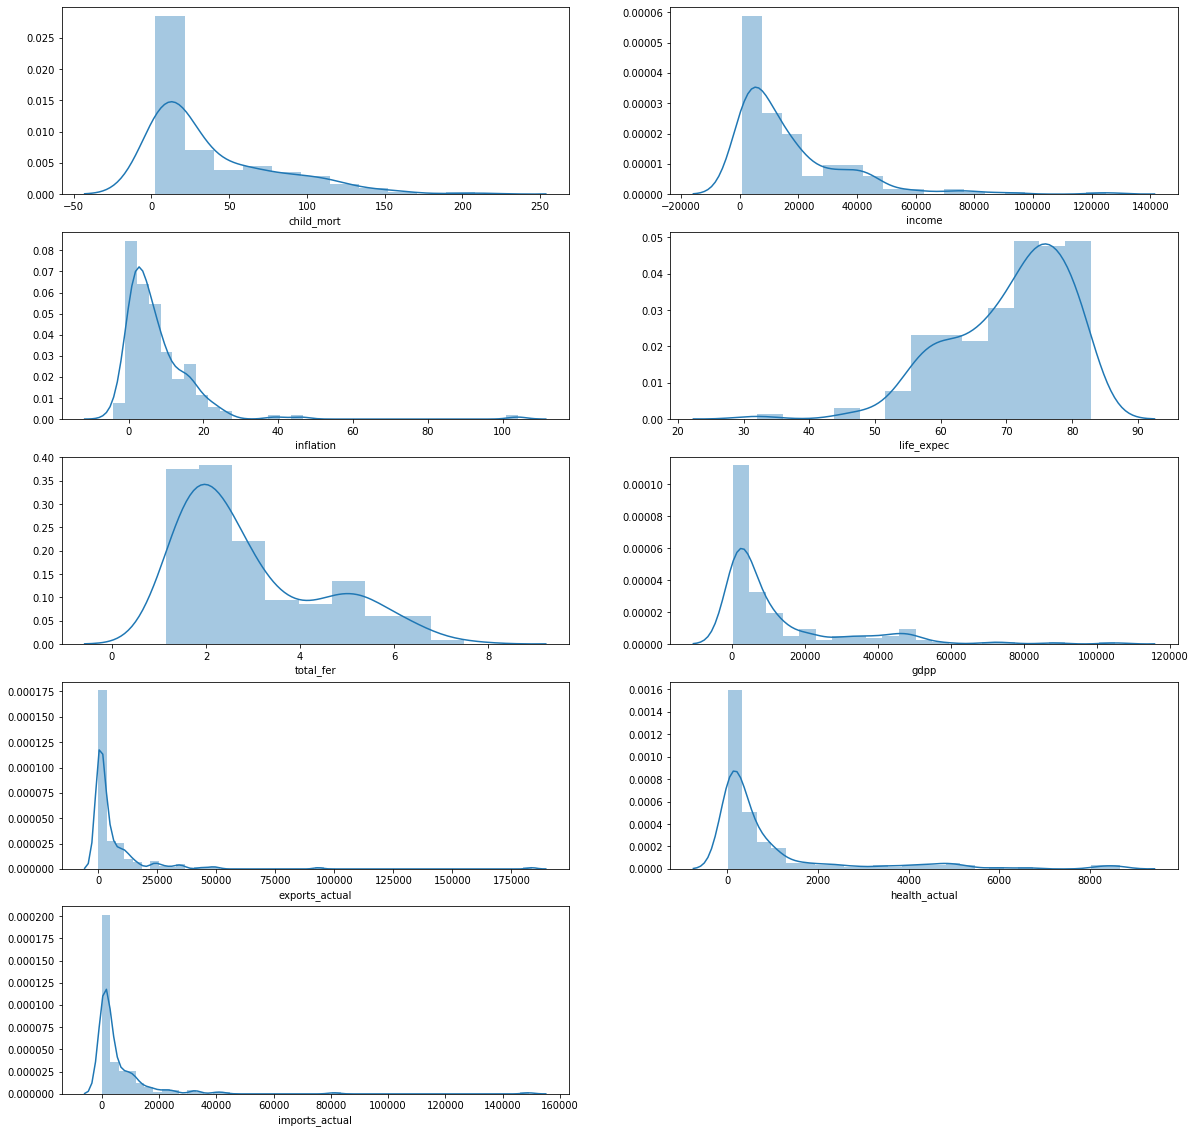

In [359]:
plt.figure(figsize = (20,20))
feature = country_df.columns[1:]
for i in enumerate(feature):
    plt.subplot(5,2, i[0]+1)
    sns.distplot(country_df[i[1]])

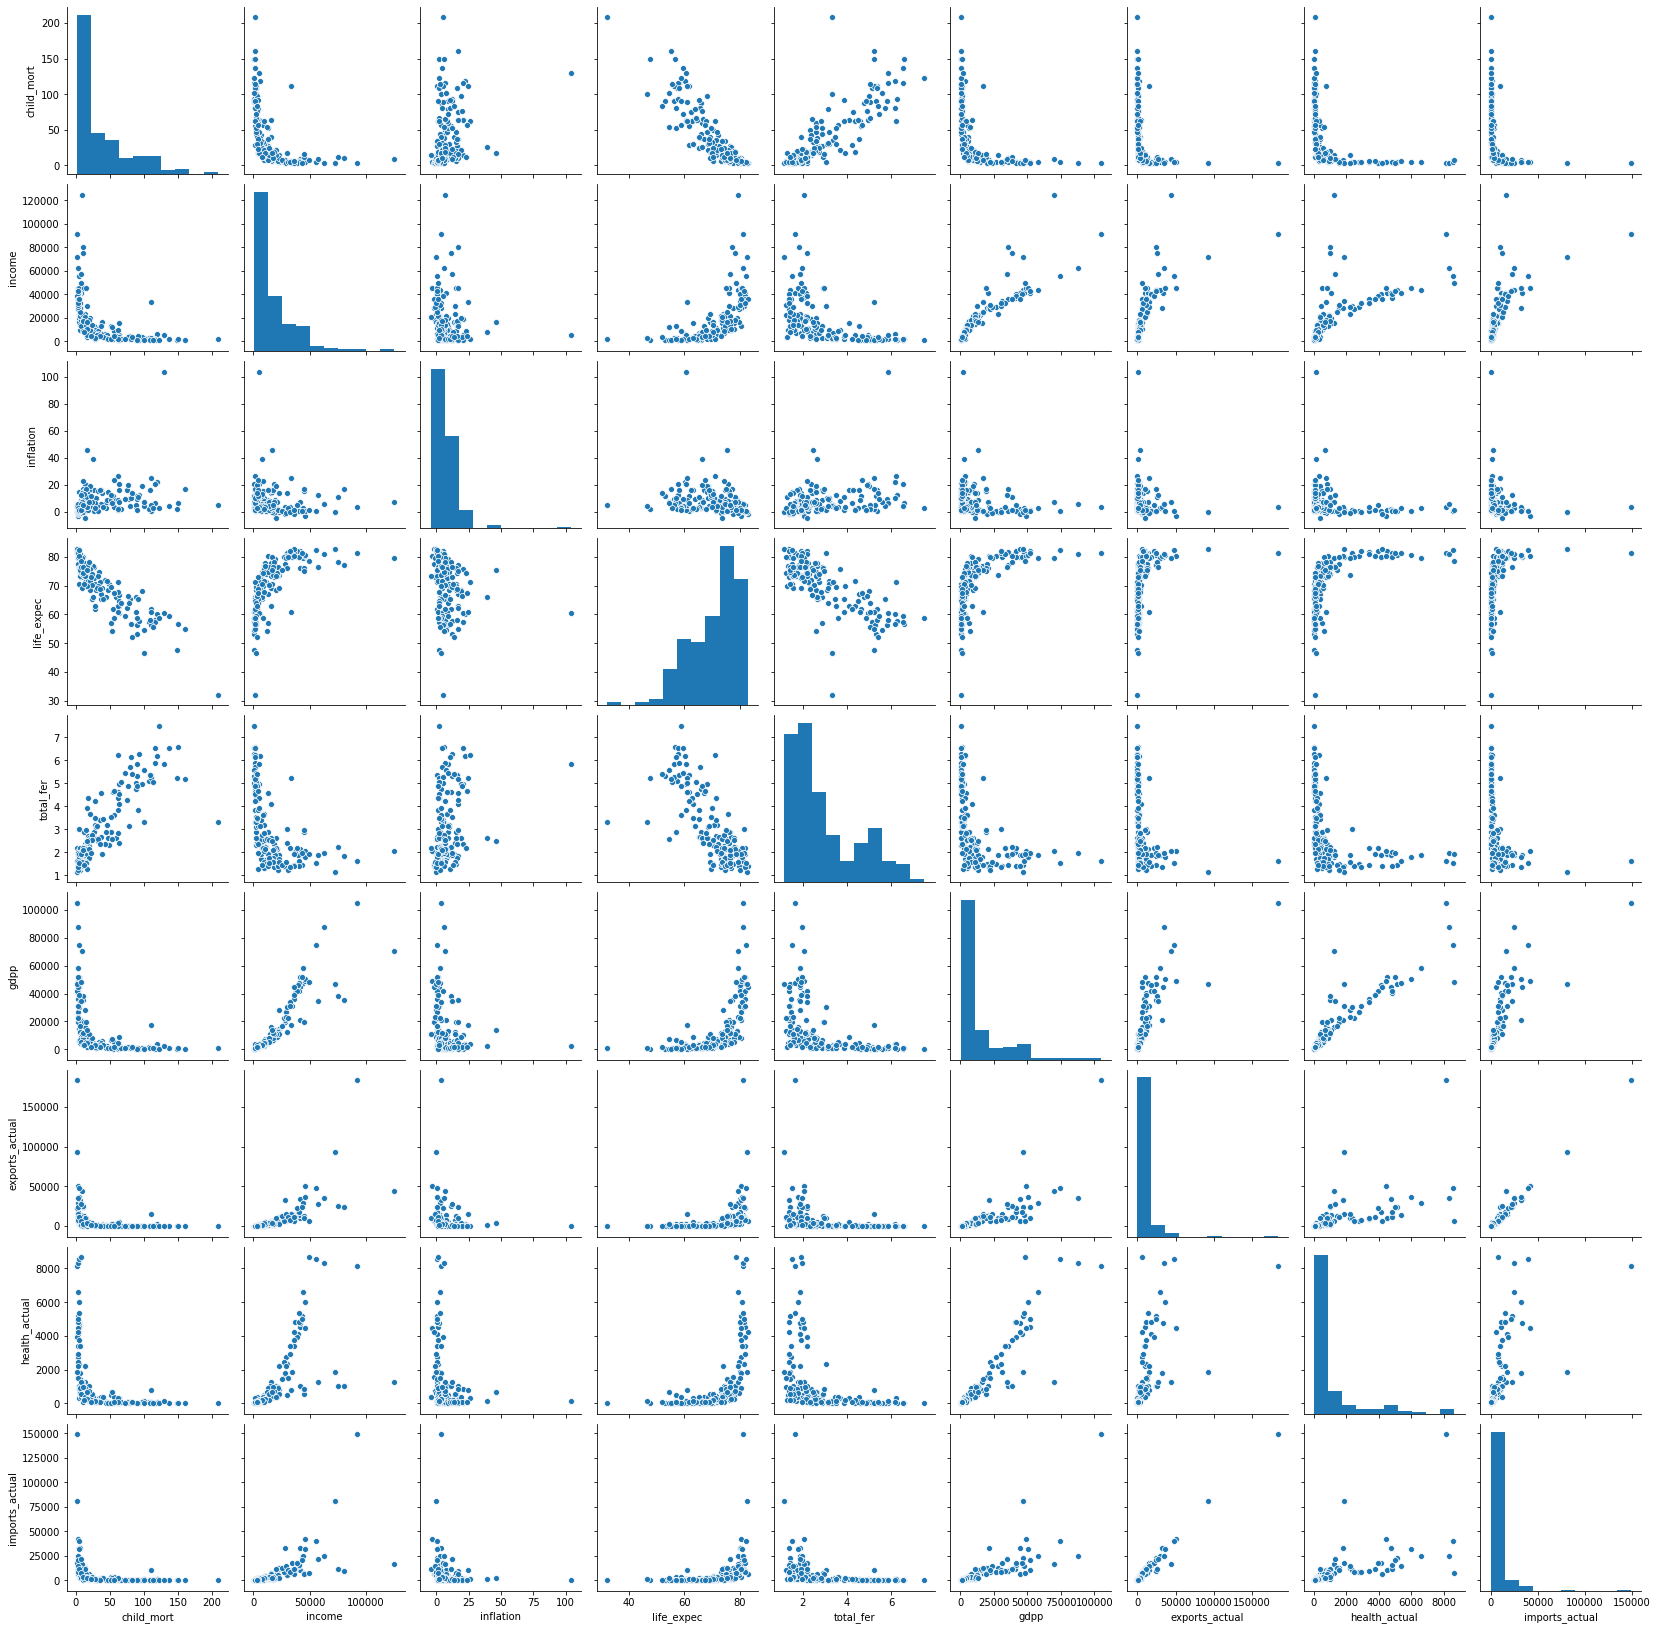

In [360]:
# Visualization with pairplot 
sns.pairplot(country_df)
plt.show()

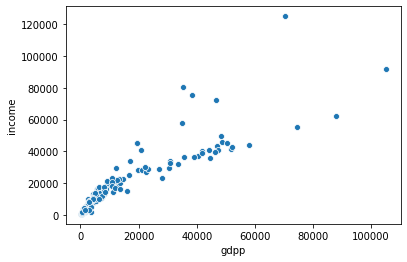

In [361]:
sns.scatterplot(x="gdpp", y="income", data=country_df)
plt.show()

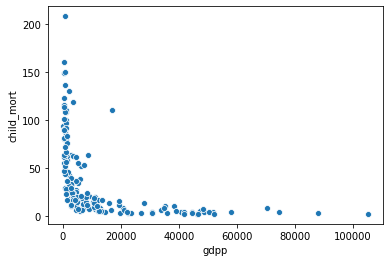

In [362]:
sns.scatterplot(x="gdpp", y="child_mort", data=country_df)
plt.show()

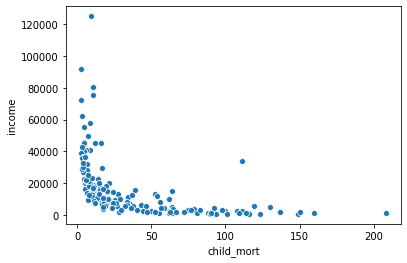

In [363]:
sns.scatterplot(x="child_mort", y="income", data=country_df)
plt.show()

## Outlier Treatment
- Outlier checking for only three columns, `income, gdpp, child_mort`

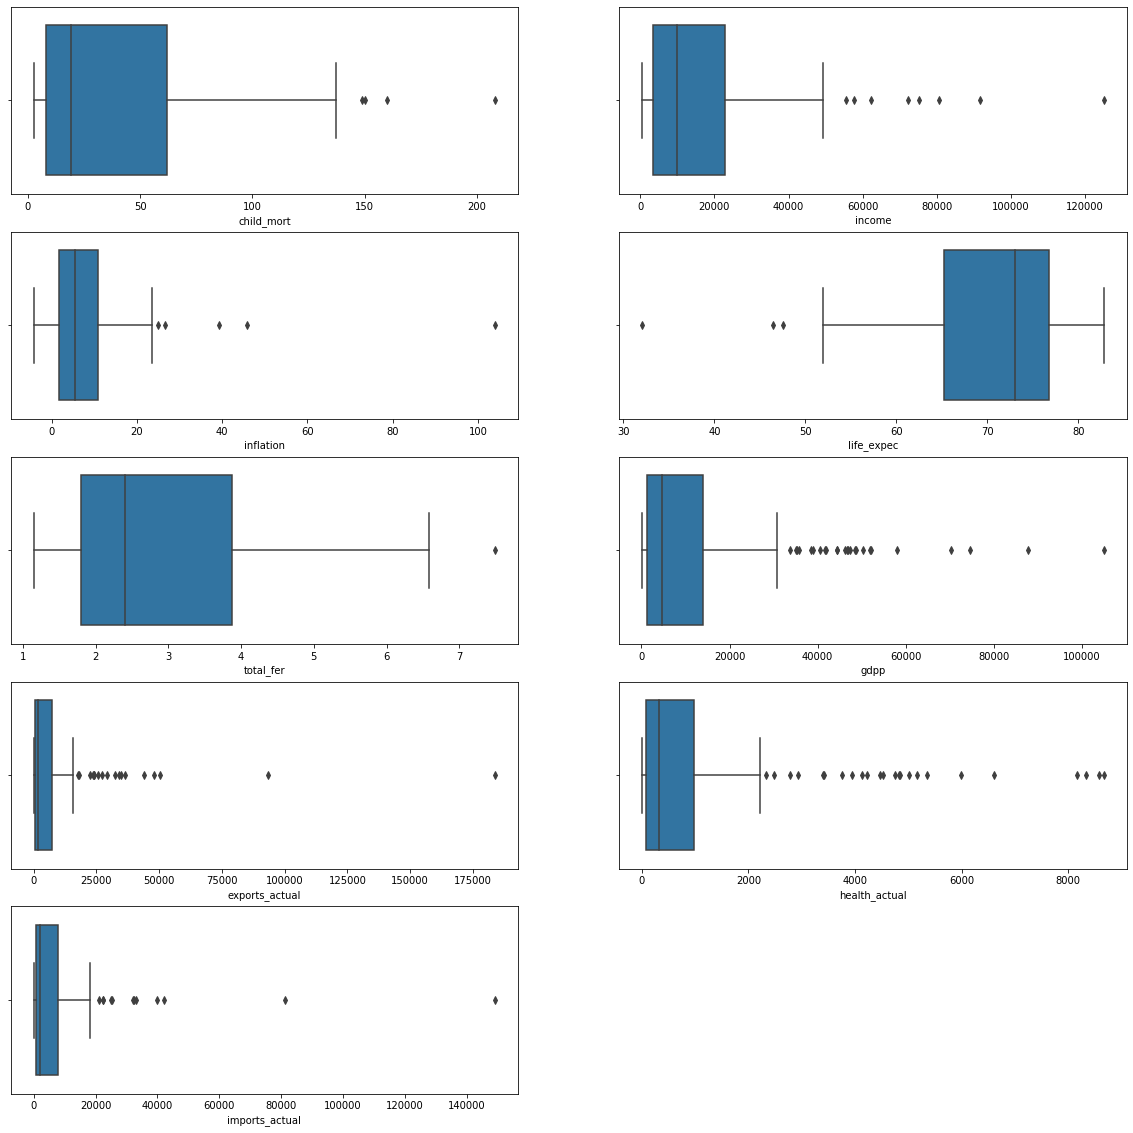

In [364]:
plt.figure(figsize = (20,20))
feature = country_df.columns[1:]
for i in enumerate(feature):
    plt.subplot(5,2, i[0]+1)
    sns.boxplot(country_df[i[1]])

 ### As we can see, 
 - there are upper/lower outlier in all the columns. But we will do analysis and clustering using three columns`(gdpp, income, child_mort)`
 - gdpp, income, child_mort is having upper outliers so we have to treat them.
 - child_mort we can not treat upper outliers

In [365]:
cluster_varlist = ['gdpp','income','child_mort']

In [366]:
# capping the columns

u1 = country_df['income'].quantile(0.95)
u2 = country_df['gdpp'].quantile(0.95)

country_df['income'][country_df['income'] >= u1] = u1
country_df['gdpp'][country_df['gdpp'] >= u2] = u2


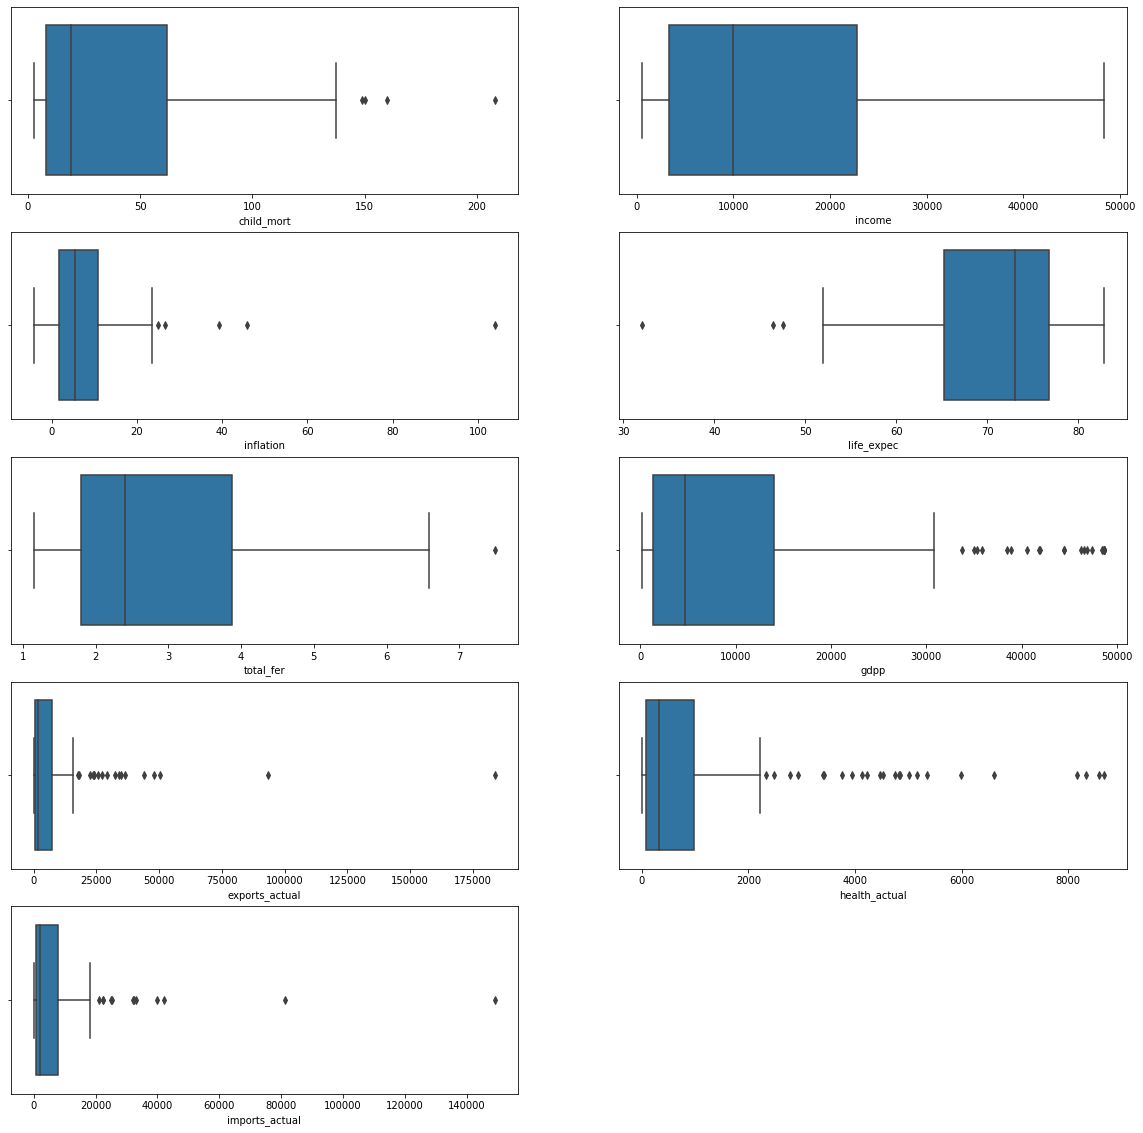

In [367]:
plt.figure(figsize = (20,20))
feature = country_df.columns[1:]
for i in enumerate(feature):
    plt.subplot(5,2, i[0]+1)
    sns.boxplot(country_df[i[1]])

In [368]:
country_df.shape

(167, 10)

## Clustering

In [369]:
# Check the hopkins

#Calculating the Hopkins statistic
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [370]:
# hopking avg is more then 90%
hopkins(country_df.drop('country', axis = 1))

0.9815257396258309

- hopking avg is always more then 90%. So we ca say the data is good for clustering

## Scaling the data

In [371]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(country_df.drop('country', axis = 1))
df_scaled

array([[ 1.29153238, -0.95834891,  0.15733622, ..., -0.4110113 ,
        -0.56503989, -0.4322755 ],
       [-0.5389489 , -0.3940062 , -0.31234747, ..., -0.35019096,
        -0.43921769, -0.31367739],
       [-0.27283273, -0.19255214,  0.78927429, ..., -0.31852577,
        -0.48482608, -0.35372048],
       ...,
       [-0.37231541, -0.76299951,  0.40973191, ..., -0.36146329,
        -0.53848844, -0.37757179],
       [ 0.44841668, -0.76367781,  1.50091625, ..., -0.39216643,
        -0.55059641, -0.41847942],
       [ 1.11495062, -0.84507339,  0.59001454, ..., -0.38395214,
        -0.54049845, -0.41844533]])

In [372]:
df_scaled = pd.DataFrame(df_scaled, columns = country_df.columns[1:])
df_scaled.head()

,child_mort,income,inflation,life_expec,total_fer,gdpp,exports_actual,health_actual,imports_actual
0,1.291532,-0.958349,0.157336,-1.619092,1.902882,-0.757362,-0.411011,-0.565040,-0.432276
1,-0.538949,-0.394006,-0.312347,0.647866,-0.859973,-0.523321,-0.350191,-0.439218,-0.313677
2,-0.272833,-0.192552,0.789274,0.670423,-0.038404,-0.498838,-0.318526,-0.484826,-0.353720
3,2.007808,-0.667360,1.387054,-1.179234,2.128151,-0.560376,-0.291375,-0.532363,-0.345953
4,-0.695634,0.227992,-0.601749,0.704258,-0.541946,0.013312,-0.104331,-0.178771,0.040735


## K-Mean Clustering

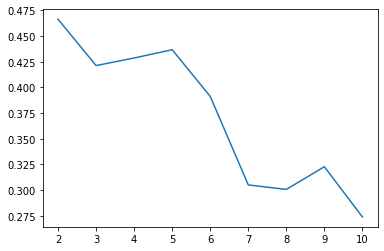

In [373]:
# Choose the value of K
# Silhouette score
# Elbow curve-ssd

ss = []
for k in range(2, 11):
    kmean = KMeans(n_clusters = k).fit(df_scaled)
    ss.append([k, silhouette_score(df_scaled, kmean.labels_)])
    
temp = pd.DataFrame(ss)    
plt.plot(temp[0], temp[1])

# Based on Silhouette score we can chose k = 3

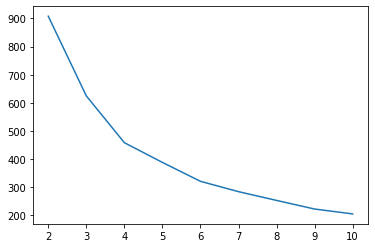

In [374]:
ssd = []
for k in range(2, 11):
    kmean = KMeans(n_clusters = k).fit(df_scaled)
    ssd.append([k, kmean.inertia_])
    
temp = pd.DataFrame(ssd)
plt.plot(temp[0], temp[1])

# baed Elbow curve-ssd graph we can see the are 3 and 4 we can see the k but we always chose lower so k=3

In [375]:
# K=3
# Final Kmean Clustering

kmean = KMeans(n_clusters = 3, random_state = 50)
kmean.fit(df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=50, tol=0.0001, verbose=0)

In [376]:
df_kmean = country_df.copy()

In [377]:
cluster  = pd.DataFrame(kmean.labels_, columns= ['cluster'])
cluster.head()

,cluster
0,2
1,0
2,0
3,2
4,0


In [378]:
df_kmean = pd.concat([df_kmean, cluster], axis =1)
df_kmean.head()

,country,child_mort,income,inflation,life_expec,total_fer,gdpp,exports_actual,health_actual,imports_actual,cluster
0,Afghanistan,90.2,1610.0,9.44,56.2,5.82,553,55.30,41.9174,248.297,2
1,Albania,16.6,9930.0,4.49,76.3,1.65,4090,1145.20,267.8950,1987.740,0
2,Algeria,27.3,12900.0,16.10,76.5,2.89,4460,1712.64,185.9820,1400.440,0
3,Angola,119.0,5900.0,22.40,60.1,6.16,3530,2199.19,100.6050,1514.370,2
4,Antigua and Barbuda,10.3,19100.0,1.44,76.8,2.13,12200,5551.00,735.6600,7185.800,0


In [379]:
df_kmean.cluster.value_counts()

0    88
2    48
1    31
Name: cluster, dtype: int64

### Plot the cluster

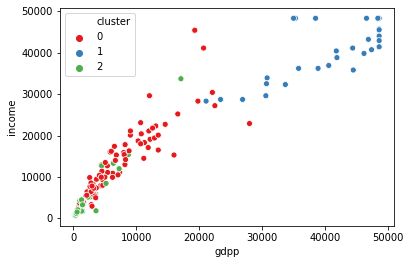

In [380]:
# Plot the cluster on gdpp, income
sns.scatterplot(x = 'gdpp', y = 'income', hue = 'cluster', data = df_kmean, palette = 'Set1')


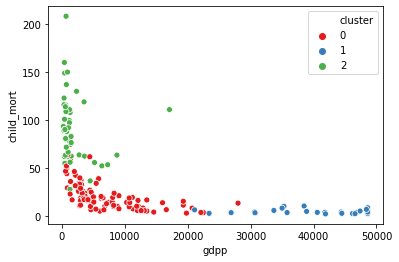

In [381]:
# Plot the cluster on gdpp, child_mort
sns.scatterplot(x = 'gdpp', y = 'child_mort', hue = 'cluster', data = df_kmean, palette = 'Set1')


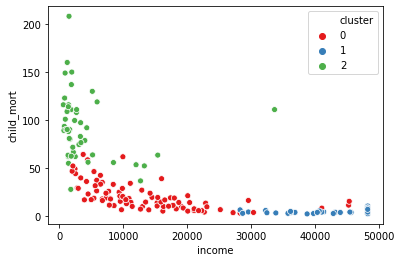

In [382]:
# Plot the cluster on income, child_mort
sns.scatterplot(x = 'income', y = 'child_mort', hue = 'cluster', data = df_kmean, palette = 'Set1')


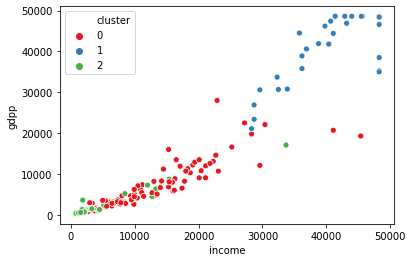

In [383]:
# Plot the cluster on income, gdpp
sns.scatterplot(x = 'income', y = 'gdpp', hue = 'cluster', data = df_kmean, palette = 'Set1')


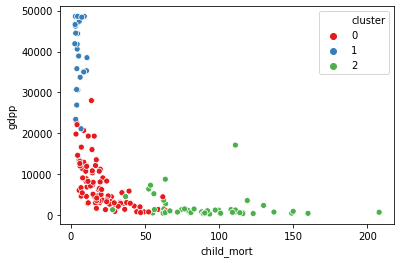

In [384]:
# Plot the cluster on child_mort, gdpp
sns.scatterplot(x = 'child_mort', y = 'gdpp', hue = 'cluster', data = df_kmean, palette = 'Set1')


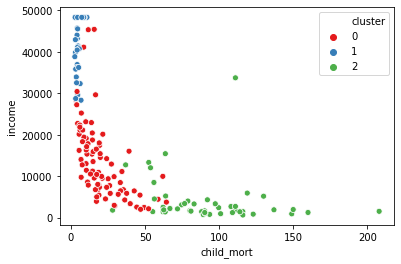

In [385]:
# Plot the cluster on child_mort, income
sns.scatterplot(x = 'child_mort', y = 'income', hue = 'cluster', data = df_kmean, palette = 'Set1')


## Clsuter Profiling

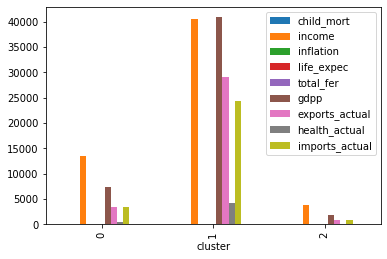

In [386]:
# Making sense out of the clsuters
df_kmean.drop('country', axis = 1).groupby('cluster').mean().plot(kind = 'bar')

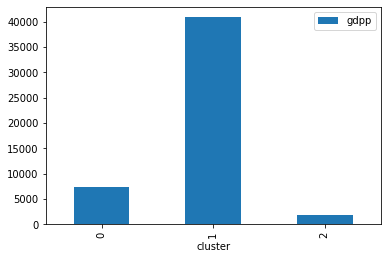

In [387]:
# GDP, INCOME AND CHID_MORT
cluster_varlist = ['gdpp', 'cluster']
df_kmean[cluster_varlist].groupby('cluster').mean().plot(kind = 'bar')

# Low gdpp is in cluster 2

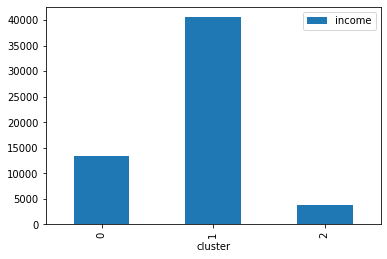

In [388]:
# GDP, INCOME AND CHID_MORT
cluster_varlist = ['income', 'cluster']
df_kmean[cluster_varlist].groupby('cluster').mean().plot(kind = 'bar')

# Low income is in cluster 2

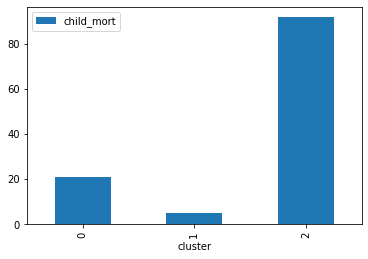

In [389]:
# GDP, INCOME AND CHID_MORT
cluster_varlist = ['child_mort', 'cluster']
df_kmean[cluster_varlist].groupby('cluster').mean().plot(kind = 'bar')

# high child_mort is in cluster 2

In [390]:
# Low income, Low GDP and High Child_mort
# Filter the data for that clsuter
df_kmean[df_kmean['cluster'] == 2]

,country,child_mort,income,inflation,life_expec,total_fer,gdpp,exports_actual,health_actual,imports_actual,cluster
0,Afghanistan,90.2,1610.0,9.440,56.2,5.82,553,55.3000,41.9174,248.297,2
3,Angola,119.0,5900.0,22.400,60.1,6.16,3530,2199.1900,100.6050,1514.370,2
17,Benin,111.0,1820.0,0.885,61.8,5.36,758,180.4040,31.0780,281.976,2
21,Botswana,52.5,13300.0,8.920,57.1,2.88,6350,2768.6000,527.0500,3257.550,2
25,Burkina Faso,116.0,1430.0,6.810,57.9,5.87,575,110.4000,38.7550,170.200,2
26,Burundi,93.6,764.0,12.300,57.7,6.26,231,20.6052,26.7960,90.552,2
28,Cameroon,108.0,2660.0,1.910,57.3,5.11,1310,290.8200,67.2030,353.700,2
31,Central African Republic,149.0,888.0,2.010,47.5,5.21,446,52.6280,17.7508,118.190,2
32,Chad,150.0,1930.0,6.390,56.5,6.59,897,330.0960,40.6341,390.195,2
36,Comoros,88.2,1410.0,3.870,65.9,4.75,769,126.8850,34.6819,397.573,2


## Filter K-Mean Cluster top 5 countries
- Low income, Low GDP and High Child_mort
- Filter the data for that clsuter

In [391]:
# Top 5 countries with low income, low gdpp and high child_mort

df_kmean[df_kmean['cluster'] == 2].sort_values(by = 
                                               ['income', 'gdpp', 'child_mort'],
                                               ascending = [True, True, False]).head(5)

,country,child_mort,income,inflation,life_expec,total_fer,gdpp,exports_actual,health_actual,imports_actual,cluster
37,"Congo, Dem. Rep.",116.0,609.0,20.80,57.5,6.54,334,137.2740,26.4194,165.664,2
88,Liberia,89.3,700.0,5.47,60.8,5.02,327,62.4570,38.5860,302.802,2
26,Burundi,93.6,764.0,12.30,57.7,6.26,231,20.6052,26.7960,90.552,2
112,Niger,123.0,814.0,2.55,58.8,7.49,348,77.2560,17.9568,170.868,2
31,Central African Republic,149.0,888.0,2.01,47.5,5.21,446,52.6280,17.7508,118.190,2


# Hierarchical Clustering
- Single linkage
- Complete linkage
- Use anyone of it based on the performance for final clustering
- Plot the cluster
- Cluster profiling
- Top-5 countries based on the need or urgert AID

In [392]:
df_scaled.head()

,child_mort,income,inflation,life_expec,total_fer,gdpp,exports_actual,health_actual,imports_actual
0,1.291532,-0.958349,0.157336,-1.619092,1.902882,-0.757362,-0.411011,-0.565040,-0.432276
1,-0.538949,-0.394006,-0.312347,0.647866,-0.859973,-0.523321,-0.350191,-0.439218,-0.313677
2,-0.272833,-0.192552,0.789274,0.670423,-0.038404,-0.498838,-0.318526,-0.484826,-0.353720
3,2.007808,-0.667360,1.387054,-1.179234,2.128151,-0.560376,-0.291375,-0.532363,-0.345953
4,-0.695634,0.227992,-0.601749,0.704258,-0.541946,0.013312,-0.104331,-0.178771,0.040735


### Perform Single Linkage

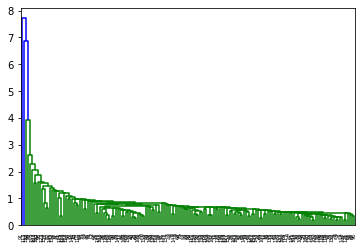

In [393]:
# single linkage
mergings = linkage(df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

### Perform Complete Linkage

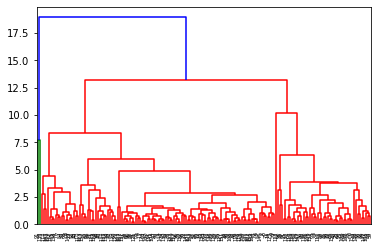

In [394]:
# complete linkage
mergings = linkage(df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

### Hierarchical Clustering
- cut_tree using k=3

In [395]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 2, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 2, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0])

In [396]:
df_kmean['hierarchical_cluster'] = cluster_labels
df_kmean.head()

,country,child_mort,income,inflation,life_expec,total_fer,gdpp,exports_actual,health_actual,imports_actual,cluster,hierarchical_cluster
0,Afghanistan,90.2,1610.0,9.44,56.2,5.82,553,55.30,41.9174,248.297,2,0
1,Albania,16.6,9930.0,4.49,76.3,1.65,4090,1145.20,267.8950,1987.740,0,1
2,Algeria,27.3,12900.0,16.10,76.5,2.89,4460,1712.64,185.9820,1400.440,0,1
3,Angola,119.0,5900.0,22.40,60.1,6.16,3530,2199.19,100.6050,1514.370,2,0
4,Antigua and Barbuda,10.3,19100.0,1.44,76.8,2.13,12200,5551.00,735.6600,7185.800,0,1


## Hierarchical Cluster Visualization

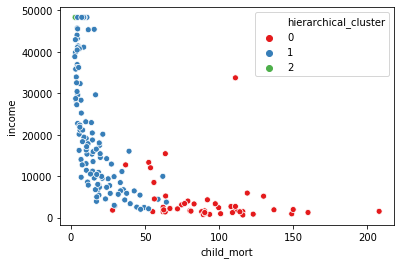

In [397]:
# Plot the cluster on child_mort, income
sns.scatterplot(x = 'child_mort', y = 'income', hue = 'hierarchical_cluster', data = df_kmean, palette = 'Set1')


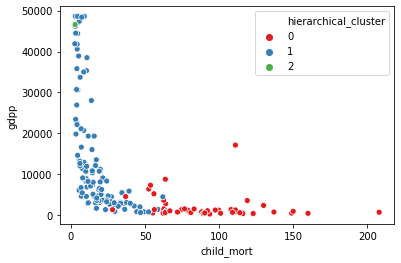

In [398]:
# Plot the cluster on child_mort, gdpp
sns.scatterplot(x = 'child_mort', y = 'gdpp', hue = 'hierarchical_cluster', data = df_kmean, palette = 'Set1')


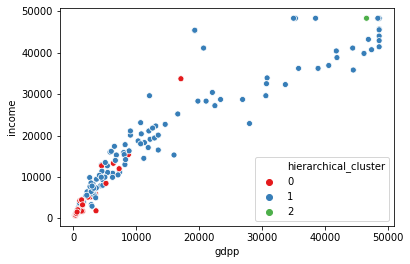

In [399]:
# Plot the cluster on gdpp, income
sns.scatterplot(x = 'gdpp', y = 'income', hue = 'hierarchical_cluster', data = df_kmean, palette = 'Set1')


In [400]:
df_kmean.hierarchical_cluster.value_counts()

1    117
0     48
2      2
Name: hierarchical_cluster, dtype: int64

## Hierarchical cluster Profiling

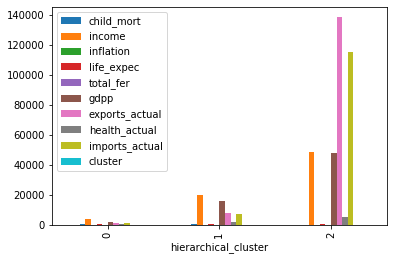

In [401]:
# Making sense out of the clsuters
df_kmean.drop('country', axis = 1).groupby('hierarchical_cluster').mean().plot(kind = 'bar')

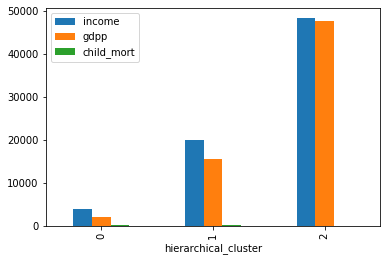

In [402]:
# Making sense out of the clsuters
varlist = ['income', 'gdpp', 'child_mort', 'hierarchical_cluster']
df_kmean[varlist].groupby('hierarchical_cluster').mean().plot(kind = 'bar')

# As we can see hierarchical_cluster 0 has the low income, low gdpp and high child_mort

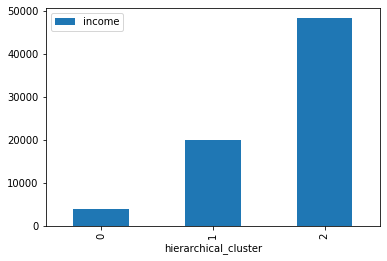

In [403]:
varlist = ['income', 'hierarchical_cluster']
df_kmean[varlist].groupby('hierarchical_cluster').mean().plot(kind = 'bar')

# As we can see hierarchical_cluster 0 has the low income, low gdpp and high child_mort

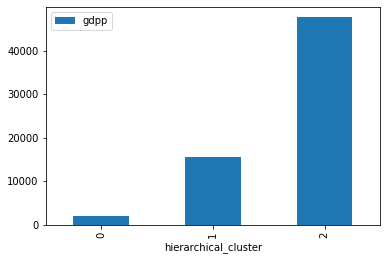

In [404]:
varlist = ['gdpp', 'hierarchical_cluster']
df_kmean[varlist].groupby('hierarchical_cluster').mean().plot(kind = 'bar')

# As we can see hierarchical_cluster 0 has the low income, low gdpp and high child_mort

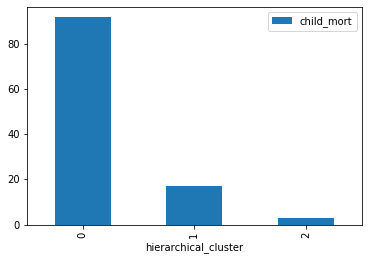

In [405]:
varlist = ['child_mort', 'hierarchical_cluster']
df_kmean[varlist].groupby('hierarchical_cluster').mean().plot(kind = 'bar')

# As we can see hierarchical_cluster 0 has the low income, low gdpp and high child_mort

- As we can see hierarchical_cluster 0 has the low income, low gdpp and high child_mort

In [406]:
# Low income, Low GDP and High Child_mort
# Filter the data for that clsuter
df_kmean[df_kmean['hierarchical_cluster'] == 0]

,country,child_mort,income,inflation,life_expec,total_fer,gdpp,exports_actual,health_actual,imports_actual,cluster,hierarchical_cluster
0,Afghanistan,90.2,1610.0,9.440,56.2,5.82,553,55.3000,41.9174,248.297,2,0
3,Angola,119.0,5900.0,22.400,60.1,6.16,3530,2199.1900,100.6050,1514.370,2,0
17,Benin,111.0,1820.0,0.885,61.8,5.36,758,180.4040,31.0780,281.976,2,0
21,Botswana,52.5,13300.0,8.920,57.1,2.88,6350,2768.6000,527.0500,3257.550,2,0
25,Burkina Faso,116.0,1430.0,6.810,57.9,5.87,575,110.4000,38.7550,170.200,2,0
26,Burundi,93.6,764.0,12.300,57.7,6.26,231,20.6052,26.7960,90.552,2,0
28,Cameroon,108.0,2660.0,1.910,57.3,5.11,1310,290.8200,67.2030,353.700,2,0
31,Central African Republic,149.0,888.0,2.010,47.5,5.21,446,52.6280,17.7508,118.190,2,0
32,Chad,150.0,1930.0,6.390,56.5,6.59,897,330.0960,40.6341,390.195,2,0
36,Comoros,88.2,1410.0,3.870,65.9,4.75,769,126.8850,34.6819,397.573,2,0


## Filter hierarchical cluster top 5 countries
- Low income, Low GDP and High Child_mort
- Filter the data for that clsuter

In [407]:

# Top 5 Countries with low income, low gdpp and high child_mort

df_kmean[df_kmean['hierarchical_cluster'] == 0].sort_values(by = 
                                               ['income', 'gdpp', 'child_mort'],
                                               ascending = [True, True, False]).head(5)

,country,child_mort,income,inflation,life_expec,total_fer,gdpp,exports_actual,health_actual,imports_actual,cluster,hierarchical_cluster
37,"Congo, Dem. Rep.",116.0,609.0,20.80,57.5,6.54,334,137.2740,26.4194,165.664,2,0
88,Liberia,89.3,700.0,5.47,60.8,5.02,327,62.4570,38.5860,302.802,2,0
26,Burundi,93.6,764.0,12.30,57.7,6.26,231,20.6052,26.7960,90.552,2,0
112,Niger,123.0,814.0,2.55,58.8,7.49,348,77.2560,17.9568,170.868,2,0
31,Central African Republic,149.0,888.0,2.01,47.5,5.21,446,52.6280,17.7508,118.190,2,0
